# Car Object Detection AI

## Libraries

In [68]:
import os, time, random
import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm
import shutil as sh
import csv

from IPython.display import Image, clear_output, display
import matplotlib.pyplot as plt

import tensorflow as tf

## Data Loading

In [26]:
solutionBox = pd.read_csv('./data/train_solution_bounding_boxes.csv')
print(solutionBox.dtypes)
print(solutionBox.shape)

image     object
xmin     float64
ymin     float64
xmax     float64
ymax     float64
dtype: object
(559, 5)


In [3]:
img_h, img_w, num_channels = (380, 676, 3)
solutionBox['image'] = solutionBox['image'].apply(lambda x: x.split('.')[0])
solutionBox['x_center'] = (solutionBox['xmin'] + solutionBox['xmax'])/2
solutionBox['y_center'] = (solutionBox['ymin'] + solutionBox['ymax'])/2
solutionBox['w'] = solutionBox['xmax'] - solutionBox['xmin']
solutionBox['h'] = solutionBox['ymax'] - solutionBox['ymin']
solutionBox['classes'] = 0
solutionBox['x_center'] = solutionBox['x_center']/img_w
solutionBox['w'] = solutionBox['w']/img_w
solutionBox['y_center'] = solutionBox['y_center']/img_h
solutionBox['h'] = solutionBox['h']/img_h
print(solutionBox.head())

         image        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0  


In [4]:
index = list(set(solutionBox.image))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'./data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_6300


(380, 676, 3)

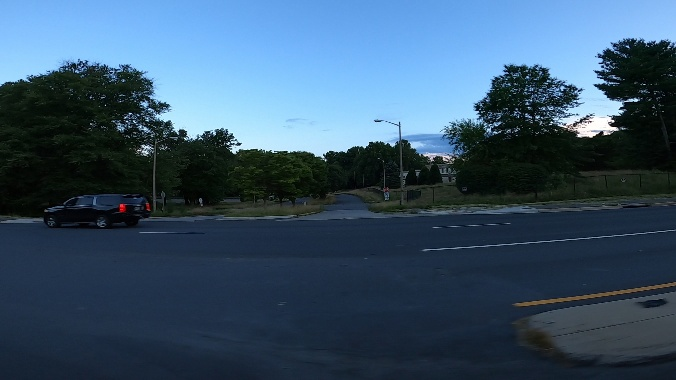

In [5]:
image = random.choice(index)
Image(filename=f'./data/training_images/{image}.jpg',width=600)

## Training

1. Split training_imgaes into val and train
2. ./tmp/images have images and ./tmp/labels have classes, x_center, y_center, w, h values

In [6]:
source = 'training_images'
val_index = index[0:len(index)//5] # [0:71]
for name,info in tqdm(solutionBox.groupby('image')):
    if name in val_index:
        save_path = 'val/'
    else:
        save_path = 'train/'
    if not os.path.exists('./tmp/labels/'+save_path):
        os.makedirs('./tmp/labels/'+save_path)
    with open('./tmp/labels/'+save_path+name+".txt", 'w+') as file:
        row = info[['classes','x_center','y_center','w','h']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            file.write(text)
            file.write("\n")
    if not os.path.exists('./tmp/images/'+save_path):
        os.makedirs('./tmp/images/'+save_path)
    sh.copy("./data/{}/{}.jpg".format(source,name),'./tmp/images/{}/{}.jpg'.format(save_path,name))

100%|██████████| 355/355 [00:00<00:00, 1034.03it/s]


In [77]:
IMG_SIZE = 50

training_data = []

def create_training_data():
    for i in range(len(os.listdir('./tmp/images/train'))):
        for img in os.listdir('./tmp/images/train'):
            img_array = cv2.imread('./tmp/images/train/'+img)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        for label in os.listdir('./tmp/labels/train'):
            with open('./tmp/labels/train/'+label) as file:
                label_array = file.read().splitlines()
        training_data.append([new_array, label_array])

create_training_data()

In [86]:
random.shuffle(training_data)

In [159]:
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

temp = np.array(y)
for i in range(len(temp)):
    y[i] = temp[i][0].split(' ')
y = np.array(y).astype(np.float)

print(X.shape, y.shape)
print(y)

(355, 50, 50, 3) (355, 5)
[[0.         0.7425346  0.52902364 0.18426803 0.10751295]
 [0.         0.7425346  0.52902364 0.18426803 0.10751295]
 [0.         0.7425346  0.52902364 0.18426803 0.10751295]
 ...
 [0.         0.7425346  0.52902364 0.18426803 0.10751295]
 [0.         0.7425346  0.52902364 0.18426803 0.10751295]
 [0.         0.7425346  0.52902364 0.18426803 0.10751295]]


/var/folders/8y/yg93b6rj7vj8gm9hg_7v89q80000gn/T/ipykernel_66950/2823443564.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y).astype(np.float)


In [148]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=X.shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(5, activation='sigmoid'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 7744)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [151]:
learning_rate = 0.001
loss_function = 'sparse_categorical_crossentropy'
batch_size = 32
num_epochs = 50

In [165]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
# model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [167]:
model.fit(x=X, y=y, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
10/10 [==============================] - 0s 19ms/step - loss: 0.4253 - accuracy: 1.0000 - val_loss: 0.4200 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 0.4192 - accuracy: 1.0000 - val_loss: 0.4177 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 0.4173 - accuracy: 1.0000 - val_loss: 0.4167 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 0.4166 - accuracy: 1.0000 - val_loss: 0.4164 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 0.4164 - accuracy: 1.0000 - val_loss: 0.4163 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 16ms/step - loss: 0.4163 - accuracy: 1.0000 - val_loss: 0.4163 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 0.4163 - accuracy: 1.0000 - val_loss: 0.4162 - val_accuracy: 1.0000
Epoch 8/10
10